# Effect of Weather on F1 Fastest Lap Times & Speed

## Introduction

The objective of this project is to determine whether or not variables such as temperature, track temperature and humidity etc may effect track fastest lap speeds, times and total laps completed.

Data is analysed from five tracks over four different seasons, from 2016 to 2019.

* Silverstone, Britain
* Albert Park, Melbourne
* Interlagos, Brazil
* Catalunya, Spain
* De spa, Belgium

Table of contents:

Overview section
* Data Preparation
* Some other section
* Another section

## Data Preparation

### Preliminaries

In [222]:
# Module Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn import linear_model
import statsmodels.api as sm

#to center graphs on notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


In [223]:
# Helper functions
def to_milliseconds(string):
    string = string.replace(".", ":").split(":")
    minutes = int(string[0])
    seconds = int(string[1])
    milliseconds = int(string[2])
    return (minutes * 60000) + (seconds * 1000) + milliseconds

to_milliseconds("1:28.604")

88604

### Reading in Data & Cleaning

In [224]:
# Read invididual data files
races = pd.read_csv('https://raw.githubusercontent.com/floeck/formula-1-major-project/master/data/formula-1/races.csv', sep = ',')
results = pd.read_csv('../data/formula-1/results.csv', sep = ',')
track_weather = pd.read_csv('../data/weather/track_weather.csv', sep = ',')

# Drop unneccesary columns
races = races.drop(columns = ['year', 'circuitId', 'round', 'time', 'url'])
results = results.drop(columns = ['resultId', 'driverId', 'constructorId', 'number', 'grid', 'position',
                                  'positionText', 'positionOrder', 'points', 'laps', 'fastestLap', 'time',
                                  'milliseconds', 'fastestLap', 'rank'])

# Update problem data in columns & query only those with races finishes
results = results.replace(r'\\N','null', regex=True)
results = results.loc[results['fastestLapTime'] != 'null']
results = results.drop(columns = ['statusId'])
results['fastestLapSpeed'] = results['fastestLapSpeed'].astype(float)

# Convert fastest time to milliseconds
results['fastestLapTime'] = results['fastestLapTime'].apply(to_milliseconds)

# Group by race and track and average fastest lap and top speed for race
races_results = races.merge(results, on = 'raceId').groupby(['raceId', 'name', 'date']).mean()

df = races_results.merge(track_weather, on = 'date')

# Add rain column
rain_desc = ["rain", "shower", "drizzle", "wet"]
df['rain'] = np.where(df['weather'].str.contains('|'.join(rain_desc)), 'wet', 'dry')

#remove messy weather column (various titles for same meaning, inconclusive weather, e.g ('wet/dry','dry then wet' etc))
df = df.drop(columns=['weather'])

# Add year categorical column
df['year'] = df['date'].str[:4].astype(int).astype('category')

# Export dataframe to csv for submission
df.to_csv('../data/V10FTW_Data.csv')



# Debug query for specific years/tracks
#df = df.loc[~df['track'].str.contains('|'.join(tracks))]
#df = df.loc[df['date'].str.contains('|'.join(years))]

In [225]:
#results.sample(n = 12, random_state = 998)
results.head()

,raceId,fastestLapTime,fastestLapSpeed
0,18,87452,218.300
1,18,87739,217.586
2,18,88090,216.719
3,18,88603,215.464
4,18,87418,218.385


## Data Plots

### Basic Scatter Plots

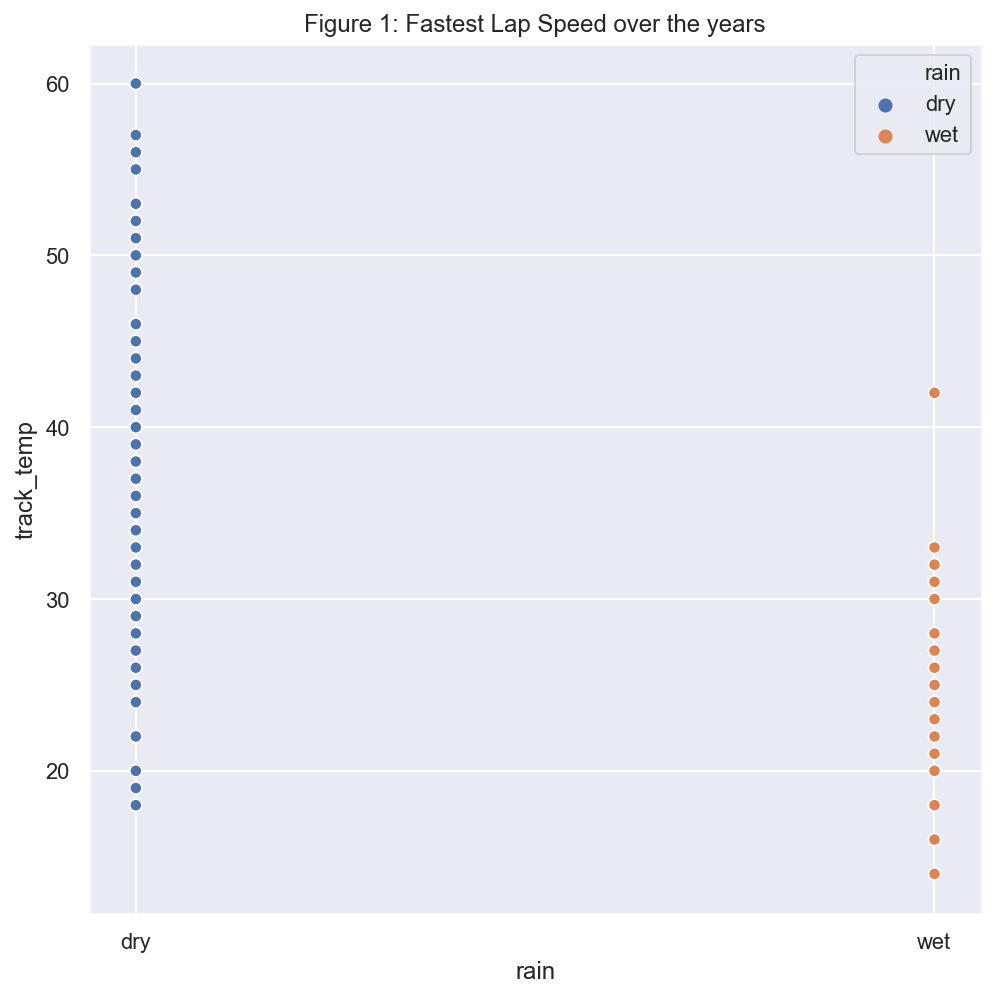

In [226]:
# create scatterplot 
sns.set(rc={'figure.figsize':(8,8)})

sns.scatterplot(df['rain'], df['track_temp'], hue=df['rain'])
plt.title('Figure 1: Fastest Lap Speed over the years')
plt.legend(bbox_to_anchor=(1,1))
plt.show();




In [227]:
# fit linear regression temp 	track_temp 	humidity 	air_pressure 	wind_speed 	wind_direction 	rain
X = df[['track_temp', 'wind_speed', 'year']]
Y = df['fastestLapTime']

# convert categorical into dummy/indicator variables
X = pd.get_dummies(data=X, drop_first=True)

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# prediction with sklearn

track_temp = 24
humidity = 80
air_pressure = 1000
wind_speed = 2
rain = 0
year = 2016
#print ('Predicted Fastest Lap Speed: \n', regr.predict([[track_temp, humidity, wind_speed, rain, year]]))

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
#predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 102659.3442220435
Coefficients: 
 [ -384.49162342   343.99589999 -3093.32541805  1865.27185668
  4877.40360358  2619.10797971  4302.91407992  2518.3315955
  6152.45561144  6009.4868061   4817.10532574  1611.73251339
   220.25973395   152.15232975]
                            OLS Regression Results                            
Dep. Variable:         fastestLapTime   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     3.059
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           0.000261
Time:                        17:22:53   Log-Likelihood:                -2286.3
No. Observations:                 215   AIC:                             4603.
Df Residuals:                     200   BIC:                             4653.
Df Model:                          14                                         
Covariance Type:            

In [228]:
# Year not much of a predictor, 
# however, 2014 - 2015 (P < 0.1) statistically significant at the 10% level
# may indicate fastest lap times in 2014, 2015 were significantly higher than base year of 2007

<br>

<br>
<h1>Data analysis</h1>
<p>Weather conditions and the effect that they have on racetimes/speeds and any relating factors.</p>

Our analysis will look at:

* Wet vs dry weather
* Track Temperatures
* Wind speeds

and their corrisponding affect on lap-times and lap-speeds.

Please note that we will not be looking at other factors (such as humidity, air temperatures , airpressure, etc) as most are caused from the above weather conditions.

<br>

<h2>Wet vs dry weather</h2>
<br>
The assumption can be made that lap times and speeds will generally be lower during periods of wet weather for safety reasons (slippery conditions). However it will be worthwhile to check just how much the affect can be on the drivers and their ability to perform in such situations.
<h3>on different circuits:</h3>
<p>Comparing different tracks and the effect that wet vs dry weather has on the fastest lap times for each..</p>
<br>

In [229]:
#No. of recorded races with with vs dry weather:
df['rain'].value_counts()

dry    182
wet     33
Name: rain, dtype: int64

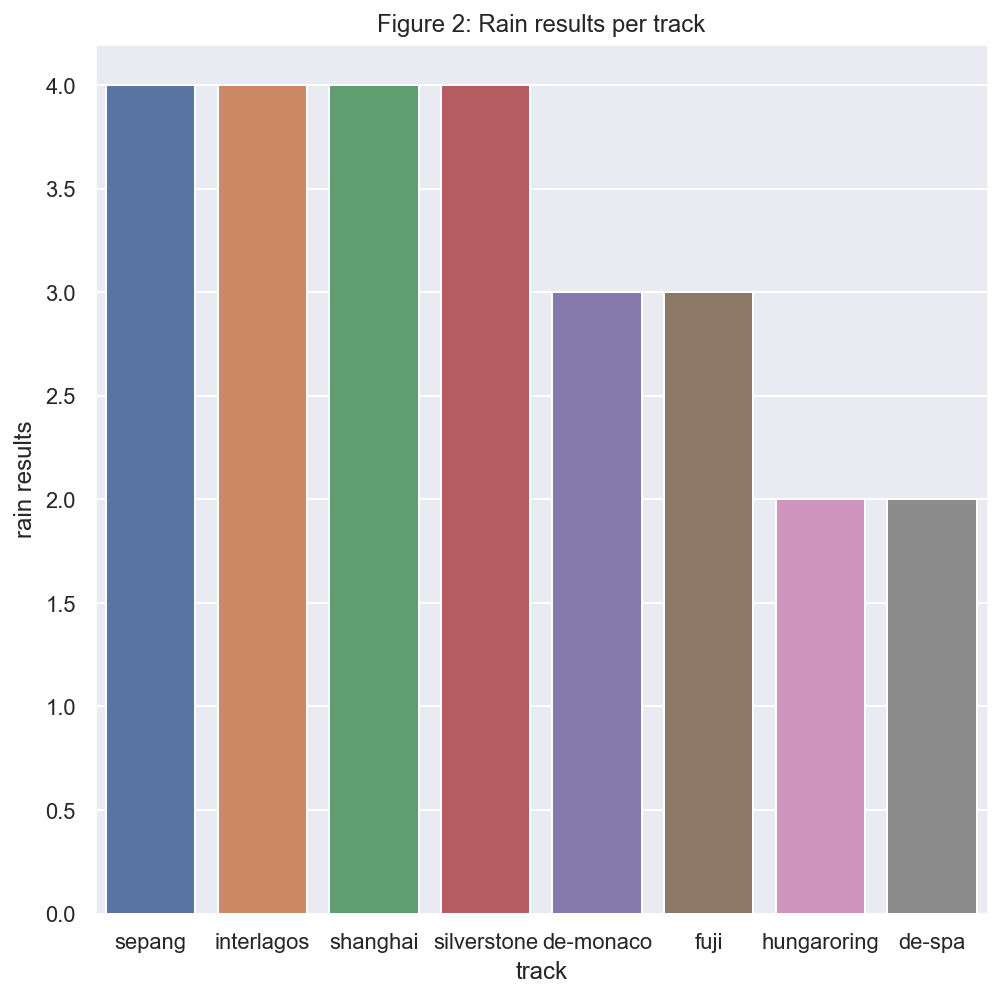

In [230]:
#Compare dry vs wet laptimes at one circuit vs another
wet = df.loc[(df['rain'] == 'wet')]

 #view and compare how many wet laptimes are recorded at each course
 #only showing top 8 results for simplicity
value_counts = wet['track'].value_counts().head(8)
sns.barplot(x=value_counts.index, y=value_counts)
plt.title('Figure 2: Rain results per track')
plt.xlabel('track')
plt.ylabel('rain results')
plt.show()

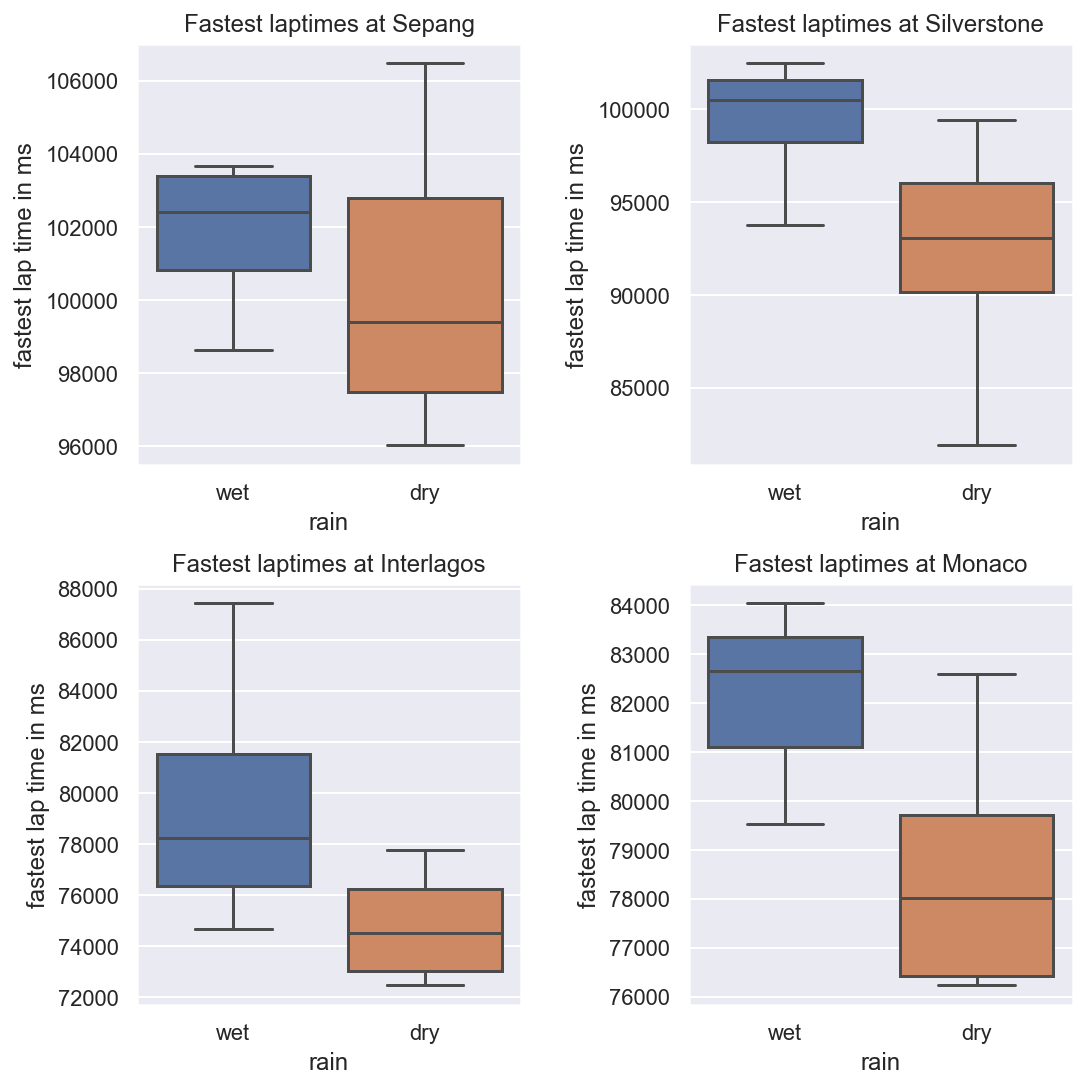

In [283]:
#Figure setup
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

silverstone = df[df['track']=='silverstone']
sepang = df[df['track']=='sepang']
interlagos = df[df['track']=='interlagos']
deMonaco = df[df['track']=='de-monaco']

#Show interlagos times
interlagosTimes = sns.boxplot(y="fastestLapTime",x="rain",data=interlagos.sort_values(by='rain',ascending=False),ax=ax3)
interlagosTimes.set(ylabel="fastest lap time in ms",title='Fastest laptimes at Interlagos')

#show sepang times
sepangTimes = sns.boxplot(y="fastestLapTime",x="rain",data=sepang.sort_values(by='rain',ascending=False),ax=ax1)
sepangTimes.set(ylabel="fastest lap time in ms",title="Fastest laptimes at Sepang")
#Show silverstone times
silverstoneTimes = sns.boxplot(y="fastestLapTime",x="rain",data=silverstone.sort_values(by='rain',ascending=False),ax=ax2)
silverstoneTimes.set(ylabel="fastest lap time in ms",title='Fastest laptimes at Silverstone')
#Show interlagos times
interlagosTimes = sns.boxplot(y="fastestLapTime",x="rain",data=interlagos.sort_values(by='rain',ascending=False),ax=ax3)
interlagosTimes.set(ylabel="fastest lap time in ms",title='Fastest laptimes at Interlagos')
#Show monaco times
monacoTimes = sns.boxplot(y="fastestLapTime",x="rain",data=deMonaco.sort_values(by='rain',ascending=False),ax=ax4)
monacoTimes.set(ylabel="fastest lap time in ms",title='Fastest laptimes at Monaco')


plt.tight_layout(pad=2, w_pad=2, h_pad=1)
plt.show()

In the above comparison, Sepang, Interlagos and Silverstone (3 of the tracks with the highest quantity of wet races, likely due to their natural climates) show that wet lap times can have a general increase on laptimes (as expected). However, this also shows that there are some outliers and external factors other than rain that can affect these lengthier times. 
Those anomolies (on both wet and dry) are likely due to either severe weather or safety factors.
All of them do however show that it is incredibly unlikely to get the fastest possible laptime in wet conditions. 

There is however some extremely impressive lap times in all of the above results given that the max whisker (in all graphs) sits in the interquartile range of the dry lap times.



<br>
<h2>Temperatures</h2>
<br>
<p>Comparing the above tracks and the affect that temps have on the laptimes.</p>
First however, a quick overview of the above track temperature and their normal distributions at each track.<br>
<br>
This will help give us an overview of the differences in the track temps at each track as well as just how much the track temps can differ over a variety of races on a given track.

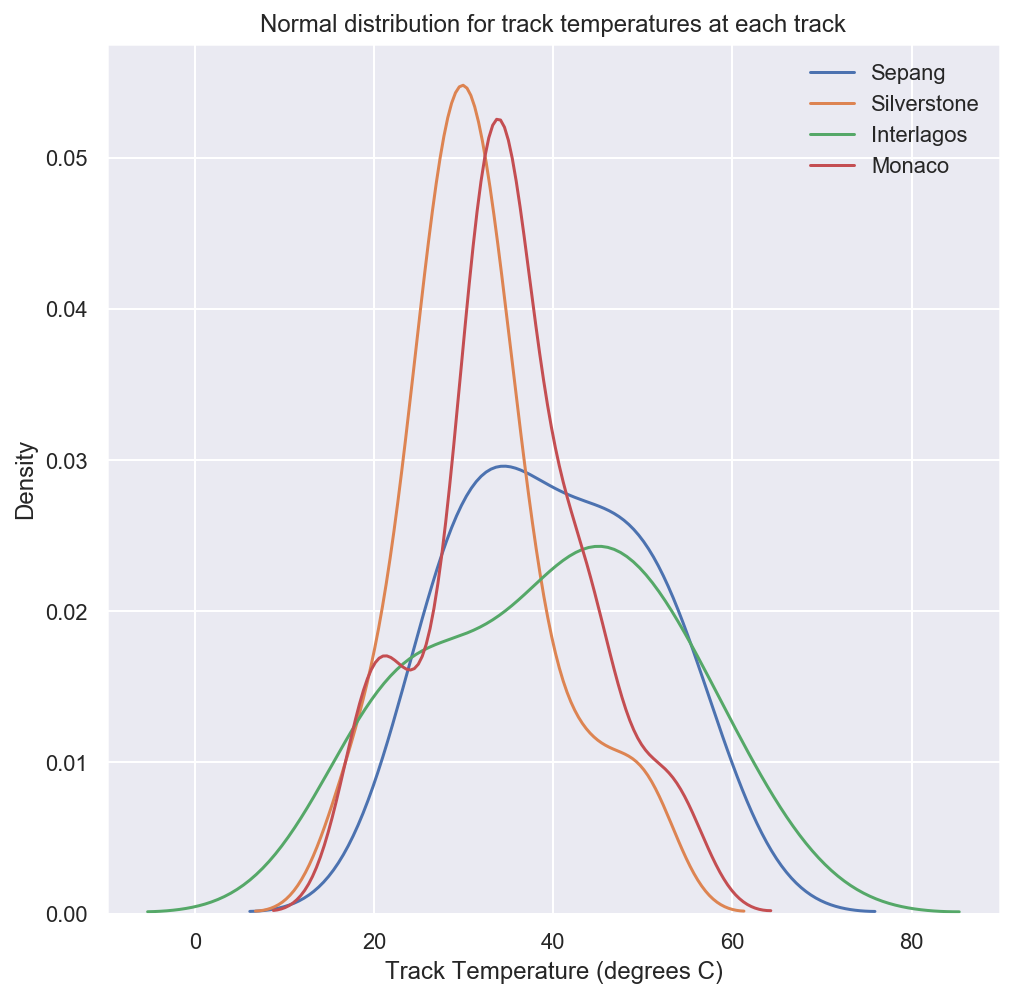

In [315]:
#Figure setup
fig = plt.figure()
ax = fig.add_subplot(111)
sns.distplot(sepang[['track_temp']],hist=False,ax=ax,label='Sepang')
sns.distplot(silverstone[['track_temp']],hist=False,ax=ax,label='Silverstone')
sns.distplot(interlagos[['track_temp']],hist=False,ax=ax,label='Interlagos')
sns.distplot(deMonaco[['track_temp']],hist=False,ax=ax,label='Monaco')
plt.title('Normal distribution for track temperatures at each track')
plt.xlabel('Track Temperature (degrees C)')
plt.ylabel('Density')
ax.legend(loc='upper right',frameon=False)
plt.show()

Before continuing, it is worth noting that this shows that Silverstone is the most left skewed of 40deg, meaning that it generally will be cooler on that track compared to the others. Interlagos has a much broader spread however appears to be generally the hotter track.

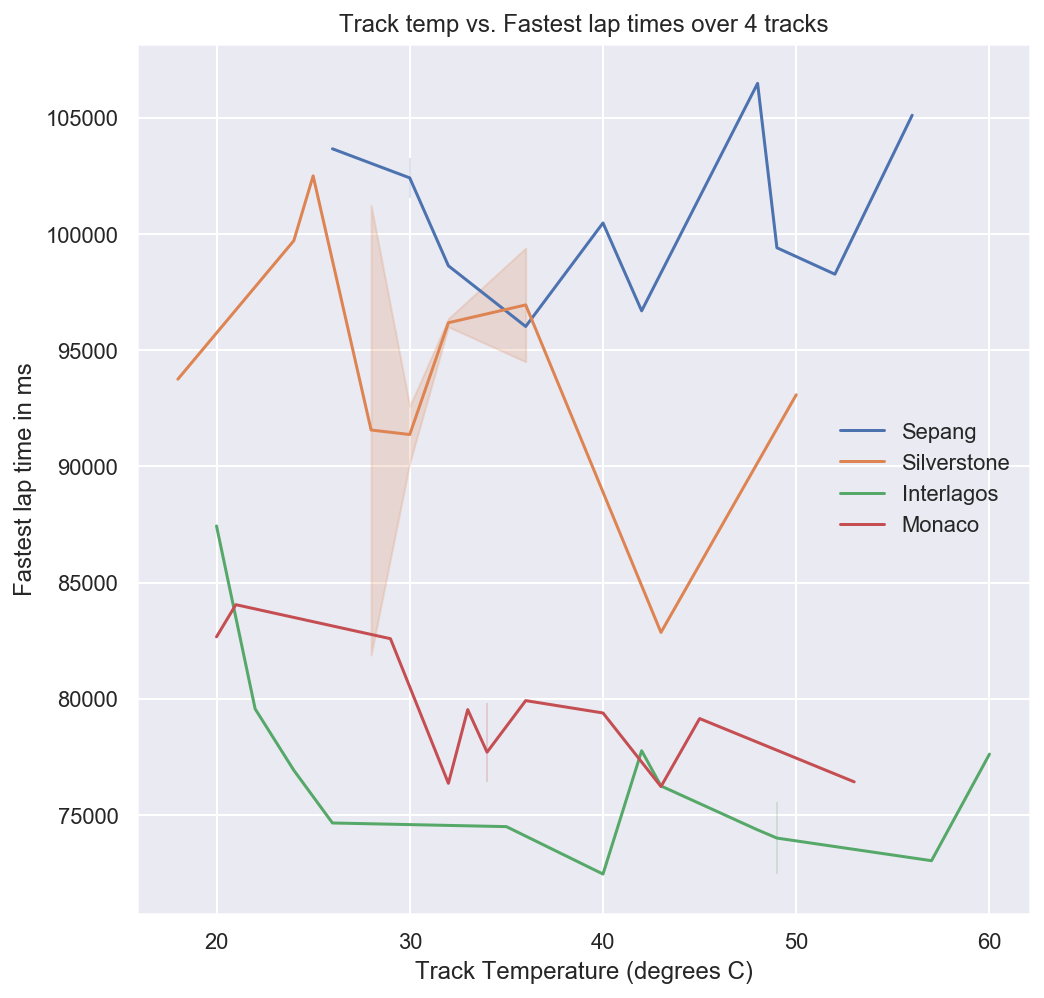

In [340]:
#Figure setup
fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.lineplot(x="track_temp",y="fastestLapTime",data=sepang,label='Sepang')
sns.lineplot(x="track_temp",y="fastestLapTime",data=silverstone,label='Silverstone')
sns.lineplot(x="track_temp",y="fastestLapTime",data=interlagos,label='Interlagos')
sns.lineplot(x="track_temp",y="fastestLapTime",data=deMonaco,label='Monaco')
plt.title('Track temp vs. Fastest lap times over 4 tracks')
plt.xlabel('Track Temperature (degrees C)')
plt.ylabel('Fastest lap time in ms')
ax1.legend(loc='center right',frameon=False)
plt.show()

Although a relationship cannot be made over all tracks, a general decrease in lap times can be seen over Interlagos, Silverstone and Monaco when track temps increase. This is suggestive that warmer tracks can play a role in reducing lap times. However, with with the exception of Monaco's results, all show that there is a threshold where high track temps can cause a spike in fastest lap times to increase. Track temps are generally hotter than the air temperature and can result in better grip, however too high can potentially degrade tyres much faster. <br>Overall it is clearly not as major a factor as wet weather was in our previous graph.

<h2>Wind Speeds</h2>